In [6]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import astropy.units as u
from astropy import constants as const
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from scipy import integrate

import diagnostic_lines
# warnings.filterwarnings("ignore")

In [2]:
all_models_with_qs = pd.read_csv('/Users/njc5787/Research/AR_05558_modeling/data/all_models_with_qs.csv', index_col=0)
all_models_with_qs = all_models_with_qs[(all_models_with_qs.age <= 8)|(all_models_with_qs.age.isna())]
BPASS_solar_path = '/Users/njc5787/Research/cloudy_model_library/cloudy_model_library_complete/BPASS/solar_abundances/'
AGN_solar_path = '/Users/njc5787/Research/cloudy_model_library/cloudy_model_library_complete/AGN/solar_abundances/'

COLOR_STARS = '#e1be6a'
COLOR_AGN = '#40b0a6'

/var/folders/cb/t7f9wn6d0_v4b9j9886w59pdjg8xs7/T/ipykernel_29420/1268396650.py:1: DtypeWarning: Columns (211,212,213,214) have mixed types. Specify dtype option on import or set low_memory=False.
  all_models_with_qs = pd.read_csv('/Users/njc5787/Research/AR_05558_modeling/data/all_models_with_qs.csv', index_col=0)


/var/folders/cb/t7f9wn6d0_v4b9j9886w59pdjg8xs7/T/ipykernel_29420/1122020613.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(filename, delimiter='\t+', comment='##')
/var/folders/cb/t7f9wn6d0_v4b9j9886w59pdjg8xs7/T/ipykernel_29420/1122020613.py:179: RuntimeWarning: divide by zero encountered in log10
  ax.plot(match_con.wave, np.log10(np.array(match_con['incident'])/match_con[match_con.wave == 1.50053e+03]['incident'].iloc[0]), color=COLOR_STARS, lw=1, alpha=1)
/var/folders/cb/t7f9wn6d0_v4b9j9886w59pdjg8xs7/T/ipykernel_29420/1122020613.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'

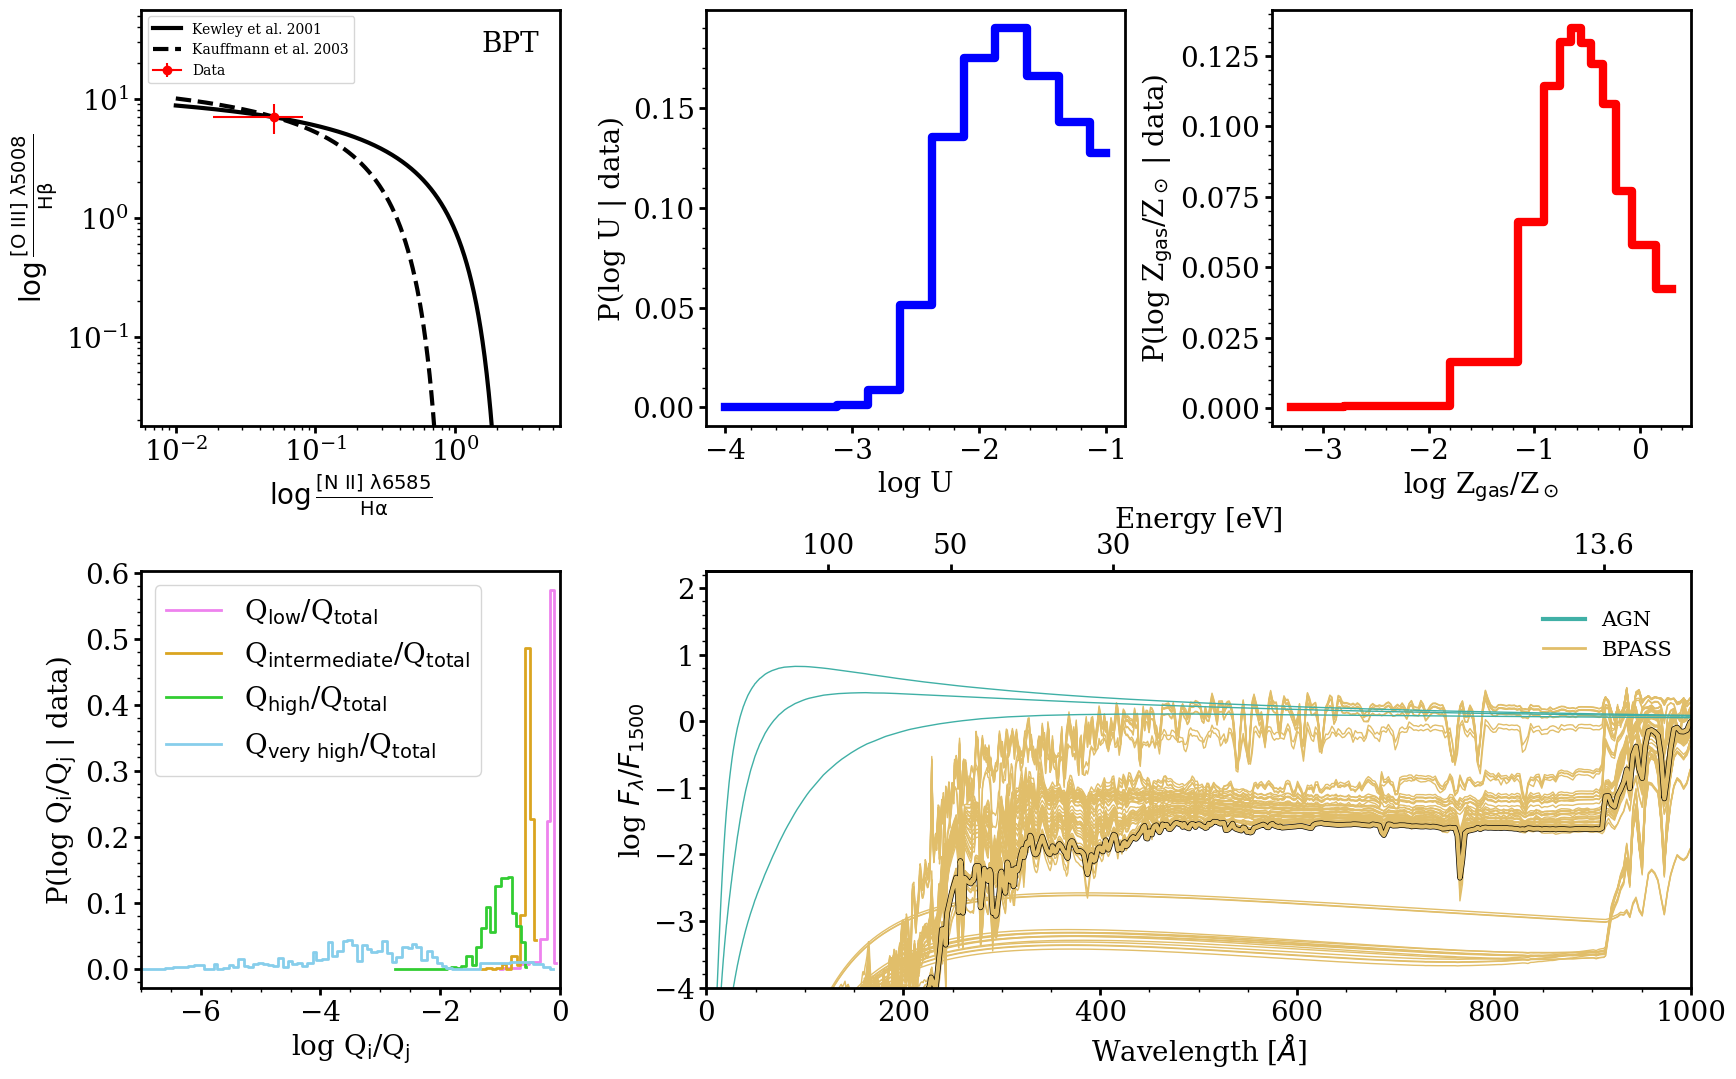

In [55]:
def clean_cloudy_con_file(filename):
    '''
    My method for making cloudy continuum files which are run on a single grid
    more user friendly. 
    '''
    df = pd.read_csv(filename, delimiter='\t+', comment='##')
    df = df.rename(columns={'#Cont  nu':'wave'})
    # df['step'] = np.zeros(len(df['wave']))
    # df['step'] = pd.qcut(df.index, int(len(df['wave'])/df['wave'].nunique()))
    # df['step'] = df['step'].cat.rename_categories(np.arange(0,len(df['step'].unique())))
    
    return df

def get_wavelength_from_ev(energy_eV):
    '''
    Takes photon energy in eV and returns corresponding wavelength in Angstroms
    '''
    return (const.h*const.c/(energy_eV*u.eV)).to(u.Angstrom).value

def make_all_qs(all_models_with_qs):
    all_qs = (
        all_models_with_qs.reset_index()[['zstar', 'age', 'binary_or_single', 'history', 'imf', 'Q_total', 'Q_low', 'Q_intermediate', 'Q_high', 'Q_very_high', 'mbh']]
        .drop_duplicates(subset=['zstar', 'age', 'binary_or_single', 'history', 'imf', 'Q_total', 'Q_low', 'Q_intermediate', 'Q_high', 'Q_very_high', 'mbh'], keep='last')
    .assign(
        Q_intermediate_Q_low = lambda x: x.Q_intermediate/x.Q_low,
        Q_high_Q_low = lambda x: x.Q_high/x.Q_low,
        Q_high_Q_intermediate = lambda x: x.Q_high/x.Q_intermediate,
        Q_very_high_Q_low = lambda x: x.Q_very_high/x.Q_low,
        Q_very_high_Q_intermediate = lambda x: x.Q_very_high/x.Q_intermediate,
        Q_very_high_Q_high = lambda x: x.Q_very_high/x.Q_high,
    ))
    return all_qs

def log_likelihood(data, model, uncertainty):
    return -0.5 * (data - model) ** 2 / uncertainty**2

def calculate_bpt_inference_df(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty):
    NII_Ha_data = np.array([NII_Ha_data])
    OIII_Hb_data = np.array([OIII_Hb_data])
    NII_Ha_uncertainty = np.array([NII_Ha_uncertainty])
    OIII_Hb_uncertainty = np.array([OIII_Hb_uncertainty])
    bpt_inference = pd.DataFrame(index=pd.MultiIndex.from_product([OIII_Hb_data, NII_Ha_data, all_models_with_qs.index], names=['data_OIII_Hb', 'data_NII_Ha', 'sed'])).assign(
        model_OIII = lambda x: [all_models_with_qs.at[sed, 'O_3_5006.84A'] for sed in x.index.get_level_values('sed')],
        model_Hb = lambda x: [all_models_with_qs.at[sed, 'H_1_4861.33A'] for sed in x.index.get_level_values('sed')],
        model_NII = lambda x: [all_models_with_qs.at[sed, 'N_2_6583.45A'] for sed in x.index.get_level_values('sed')],
        model_Ha = lambda x: [all_models_with_qs.at[sed, 'H_1_6562.81A'] for sed in x.index.get_level_values('sed')], 
        logU = lambda x: [all_models_with_qs.at[sed, 'logU'] for sed in x.index.get_level_values('sed')],
        zgas = lambda x: [all_models_with_qs.at[sed, 'zgas'] for sed in x.index.get_level_values('sed')],
        hden = lambda x: [all_models_with_qs.at[sed, 'hden'] for sed in x.index.get_level_values('sed')],
        age = lambda x: [all_models_with_qs.at[sed, 'age'] for sed in x.index.get_level_values('sed')],
        imf = lambda x: [all_models_with_qs.at[sed, 'imf'] for sed in x.index.get_level_values('sed')],
        binary_or_single = lambda x: [all_models_with_qs.at[sed, 'binary_or_single'] for sed in x.index.get_level_values('sed')],
        zstar = lambda x: [all_models_with_qs.at[sed, 'zstar'] for sed in x.index.get_level_values('sed')],
        mbh = lambda x: [all_models_with_qs.at[sed, 'mbh'] for sed in x.index.get_level_values('sed')],
        Q_total = lambda x: [all_models_with_qs.at[sed, 'Q_total'] for sed in x.index.get_level_values('sed')],
        Q_low = lambda x: [all_models_with_qs.at[sed, 'Q_low'] for sed in x.index.get_level_values('sed')],
        Q_intermediate = lambda x: [all_models_with_qs.at[sed, 'Q_intermediate'] for sed in x.index.get_level_values('sed')],
        Q_high = lambda x: [all_models_with_qs.at[sed, 'Q_high'] for sed in x.index.get_level_values('sed')],
        Q_very_high = lambda x: [all_models_with_qs.at[sed, 'Q_very_high'] for sed in x.index.get_level_values('sed')]
        ).reset_index().assign(
        model_OIII_Hb = lambda x: x.model_OIII/x.model_Hb,
        log_model_OIII_Hb = lambda x: np.log10(x.model_OIII_Hb),
        model_NII_Ha = lambda x: x.model_NII/x.model_Ha,
        log_model_NII_Ha = lambda x: np.log10(x.model_NII_Ha),
        log_likelihood_OIII_Hb = lambda x: log_likelihood(data=x.data_OIII_Hb, model=x.model_OIII_Hb, uncertainty=OIII_Hb_uncertainty),
        log_likelihood_NII_Ha = lambda x: log_likelihood(data=x.data_NII_Ha, model=x.model_NII_Ha, uncertainty=NII_Ha_uncertainty), 
        likelihood_BPT = lambda x: np.exp(x.log_likelihood_OIII_Hb+x.log_likelihood_NII_Ha),
        likelihood_BPT_norm = lambda x: x.likelihood_BPT/x.groupby(['data_NII_Ha', 'data_OIII_Hb'])['likelihood_BPT'].transform('sum'),
    )
    return bpt_inference


def plot_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty, ax):
    ax.errorbar(NII_Ha_data, OIII_Hb_data, xerr=NII_Ha_uncertainty, yerr=OIII_Hb_uncertainty, c='red', label='Data', marker='o')
    diagnostic_lines.plot_bpt_kewley_2001(ax, label=True)
    diagnostic_lines.plot_bpt_kauffmann_2003(ax, label=True)
    ax.set_xlim(10**-2.25, 10**0.75)
    ax.set_ylim(10**-1.75, 10**1.75)
    ax.set_xlabel(r'$\log\frac{\rm{[N~II]~\lambda6585}}{\rm{H}\alpha}$')
    ax.set_ylabel(r'$\log\frac{\rm{[O~III]}~\lambda5008}{\rm{H}\beta}$')
    ax.annotate('BPT', xy=(0.95, 0.95), xycoords='axes fraction', ha='right', va='top')
    ax.legend(fontsize=10)
    ax.set_xscale('log')
    ax.set_yscale('log')


def plot_posterior_logU(bpt_inference_df, ax):
    bpt_groupby_logU = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'logU'], observed=True).sum().reset_index()
    # q_16, q_50, q_84 = calculate_quantiles_16_50_84(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm']) 
    ax.step(bpt_groupby_logU['logU'], bpt_groupby_logU['likelihood_BPT_norm'], where='mid', lw=6, c='blue')
    # ax.axvspan(q_16, q_84, color='blue', alpha=0.25)
    # ax.axvline(q_50, c='blue', ls=':')
    ax.set_xlabel('log U')
    ax.set_ylabel('P(log U | data)')


def plot_posterior_Zgas(bpt_inference_df, ax):
    bpt_groupby_zgas = bpt_inference_df.drop('sed', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'zgas'], observed=True).sum().reset_index()
    # q_16, q_50, q_84 = calculate_quantiles_16_50_84(np.log10(bpt_groupby_zgas['zgas']), bpt_groupby_zgas['likelihood_BPT_norm'])
    ax.step(np.log10(bpt_groupby_zgas['zgas']), bpt_groupby_zgas['likelihood_BPT_norm'], where='mid', lw=6, c='red')
    # ax.axvspan(q_16, q_84, color='red', alpha=0.25)
    # ax.axvline(q_50, c='red', ls=':')
    ax.set_xlabel(r'log Z$_{\rm{gas}}$/Z$_\odot$')
    ax.set_ylabel(r'P(log Z$_{\rm{gas}}$/Z$_\odot$ | data)')


def make_bpt_groupby_Q_low_Q_total(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_low_Q_total'] = pd.cut(np.log10(bpt_inference_dummy['Q_low']/bpt_inference_dummy['Q_total']), bins=np.linspace(-15, 1.5, 200))
    bpt_inference_dummy['bins_centers_Q_low_Q_total'] = bpt_inference_dummy['bins_Q_low_Q_total'].apply(lambda x: x.mid)
    bpt_groupby_Q_low_Q_total = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_low_Q_total', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_low_Q_total'], observed=True).sum().reset_index()
    return bpt_groupby_Q_low_Q_total


def plot_posterior_Q_low_Q_total(bpt_inference_df, ax):
    bpt_groupby_Q_low_Q_total = make_bpt_groupby_Q_low_Q_total(bpt_inference_df)
    ax.step(np.log10(bpt_groupby_Q_low_Q_total['Q_low']/bpt_groupby_Q_low_Q_total['Q_total']), bpt_groupby_Q_low_Q_total['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{low}}$/Q$_{\rm{total}}$', ls='-', c='violet')


def make_bpt_groupby_Q_intermediate_Q_total(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_intermediate_Q_total'] = pd.cut(np.log10(bpt_inference_dummy['Q_intermediate']/bpt_inference_dummy['Q_total']), bins=np.linspace(-15, 1.5, 200))
    bpt_inference_dummy['bins_centers_Q_intermediate_Q_total'] = bpt_inference_dummy['bins_Q_intermediate_Q_total'].apply(lambda x: x.mid)
    bpt_groupby_Q_intermediate_Q_total = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_intermediate_Q_total', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_intermediate_Q_total'], observed=True).sum().reset_index()
    return bpt_groupby_Q_intermediate_Q_total


def plot_posterior_Q_intermediate_Q_total(bpt_inference_df, ax):
    bpt_groupby_Q_intermediate_Q_total = make_bpt_groupby_Q_intermediate_Q_total(bpt_inference_df)
    ax.step(np.log10(bpt_groupby_Q_intermediate_Q_total['Q_intermediate']/bpt_groupby_Q_intermediate_Q_total['Q_total']), bpt_groupby_Q_intermediate_Q_total['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{intermediate}}$/Q$_{\rm{total}}$', ls='-', c='goldenrod')


def make_bpt_groupby_Q_high_Q_total(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_high_Q_total'] = pd.cut(np.log10(bpt_inference_dummy['Q_high']/bpt_inference_dummy['Q_total']), bins=np.linspace(-15, 1.5, 200))
    bpt_inference_dummy['bins_centers_Q_high_Q_total'] = bpt_inference_dummy['bins_Q_high_Q_total'].apply(lambda x: x.mid)
    bpt_groupby_Q_high_Q_total = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_high_Q_total', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_high_Q_total'], observed=True).sum().reset_index()
    return bpt_groupby_Q_high_Q_total


def plot_posterior_Q_high_Q_total(bpt_inference_df, ax):
    bpt_groupby_Q_high_Q_total = make_bpt_groupby_Q_high_Q_total(bpt_inference_df)
    ax.step(np.log10(bpt_groupby_Q_high_Q_total['Q_high']/bpt_groupby_Q_high_Q_total['Q_total']), bpt_groupby_Q_high_Q_total['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{high}}$/Q$_{\rm{total}}$', ls='-', c='limegreen')

def make_bpt_groupby_Q_very_high_Q_total(bpt_inference_df):
    bpt_inference_dummy = bpt_inference_df.copy()
    bpt_inference_dummy['bins_Q_very_high_Q_total'] = pd.cut(np.log10(bpt_inference_dummy['Q_very_high']/bpt_inference_dummy['Q_total']), bins=np.linspace(-15, 1.5, 200))
    bpt_inference_dummy['bins_centers_Q_very_high_Q_total'] = bpt_inference_dummy['bins_Q_very_high_Q_total'].apply(lambda x: x.mid)
    bpt_groupby_Q_very_high_Q_total = bpt_inference_dummy.drop('sed', axis=1).drop('bins_Q_very_high_Q_total', axis=1).groupby(by=['data_NII_Ha', 'data_OIII_Hb', 'bins_centers_Q_very_high_Q_total'], observed=True).sum().reset_index()
    return bpt_groupby_Q_very_high_Q_total


def plot_posterior_Q_very_high_Q_total(bpt_inference_df, ax):
    bpt_groupby_Q_very_high_Q_total = make_bpt_groupby_Q_very_high_Q_total(bpt_inference_df)
    ax.step(np.log10(bpt_groupby_Q_very_high_Q_total['Q_very_high']/bpt_groupby_Q_very_high_Q_total['Q_total']), bpt_groupby_Q_very_high_Q_total['likelihood_BPT_norm'], where='mid', lw=2, label=r'Q$_{\rm{very~high}}$/Q$_{\rm{total}}$', ls='-', c='skyblue')

def plot_posterior_all_Q(bpt_inference_df, ax):
    plot_posterior_Q_low_Q_total(bpt_inference_df, ax)
    plot_posterior_Q_intermediate_Q_total(bpt_inference_df, ax)
    plot_posterior_Q_high_Q_total(bpt_inference_df, ax)
    plot_posterior_Q_very_high_Q_total(bpt_inference_df, ax)
    ax.set_xlabel(r'log Q$_{\rm{i}}$/Q$_{\rm{j}}$')
    ax.set_ylabel(r'P(log Q$_{\rm{i}}$/Q$_{\rm{j}}$ | data)')
    ax.set_xlim(-7, 0)
    ax.legend()

def find_model_matches(bpt_inference_df, n_most_likely):
    bpt_inference_df = bpt_inference_df.sort_values('likelihood_BPT', ascending=False).head(n_most_likely).reset_index()
    return bpt_inference_df

def plot_matches(bpt_inference_df, n_most_likely, ax):
    matches = find_model_matches(bpt_inference_df, n_most_likely)
    matches_mbh = matches[matches['sed'].str.contains('mbh')]
    matches_mbh = matches_mbh.drop_duplicates(subset=['mbh'])
    matches_BPASS = matches[~matches['sed'].str.contains('mbh')]
    matches_BPASS = matches_BPASS.drop_duplicates(subset=['imf', 'age', 'binary_or_single', 'zstar'])
    for match in matches_BPASS.sed:
        match_con = clean_cloudy_con_file(f'{BPASS_solar_path}{match}.con')
        ax.plot(match_con.wave, np.log10(np.array(match_con['incident'])/match_con[match_con.wave == 1.50053e+03]['incident'].iloc[0]), color=COLOR_STARS, lw=1, alpha=1)
    for match in matches_mbh.sed:
        match_con = clean_cloudy_con_file(f'{AGN_solar_path}{match}.con')
        ax.plot(match_con.wave, np.log10(np.array(match_con['incident'])/match_con[match_con.wave == 1.50053e+03]['incident'].iloc[0]), color=COLOR_AGN, lw=1, alpha=1)
    most_likely = matches.iloc[0]
    if 'mbh' in most_likely['sed']:
        match_con = clean_cloudy_con_file(f'{AGN_solar_path}{most_likely["sed"]}.con')
        ax.plot(match_con.wave, np.log10(np.array(match_con['incident'])/match_con[match_con.wave == 1.50053e+03]['incident'].iloc[0]), color='k', lw=4, alpha=1)
        ax.plot(match_con.wave, np.log10(np.array(match_con['incident'])/match_con[match_con.wave == 1.50053e+03]['incident'].iloc[0]), color=COLOR_AGN, lw=3, alpha=1)
    if 'BPASS' in most_likely['sed']:
        match_con = clean_cloudy_con_file(f'{BPASS_solar_path}{most_likely["sed"]}.con')
        ax.plot(match_con.wave, np.log10(np.array(match_con['incident'])/match_con[match_con.wave == 1.50053e+03]['incident'].iloc[0]), color='k', lw=4, alpha=1)
        ax.plot(match_con.wave, np.log10(np.array(match_con['incident'])/match_con[match_con.wave == 1.50053e+03]['incident'].iloc[0]), color=COLOR_STARS, lw=3, alpha=1)

    secax = ax.secondary_xaxis('top')
    secax.set_xticks(get_wavelength_from_ev([13.6,30,50,100]))
    secax.set_xticklabels([13.6,30,50,100])
    secax.minorticks_off()
    secax.set_xlabel('Energy [eV]')

    ax.set_xlim(0, 1000)
    ax.set_ylim(-4, 2.25)
    ax.set_xlabel('Wavelength [$\AA$]')
    ax.set_ylabel('log $F_\lambda/F_{1500}$')
    legend_elements= [Line2D([0], [0], color=COLOR_AGN, lw=3, label='AGN'),
                      Line2D([0], [0], color=COLOR_STARS, lw=2, label='BPASS')
                      ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.0, 0.95), frameon=False, fontsize=15)

def main_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty, n_most_likely, plot_matched_seds=True):
    bpt_inference_df = calculate_bpt_inference_df(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty)
    matches = find_model_matches(bpt_inference_df, n_most_likely)

    fig = plt.figure(figsize=(20,20))
    gs = GridSpec(nrows=3, ncols=3)
    gs.update(wspace=0.35, hspace=0.35)

    ax = fig.add_subplot(gs[0:1, 0:1])
    plot_bpt(NII_Ha_data, OIII_Hb_data, NII_Ha_uncertainty, OIII_Hb_uncertainty, ax)

    ax = fig.add_subplot(gs[0:1, 1:2])
    plot_posterior_logU(bpt_inference_df, ax)

    ax = fig.add_subplot(gs[0:1, 2:3])
    plot_posterior_Zgas(bpt_inference_df, ax)

    ax = fig.add_subplot(gs[1:2, 0:1])
    plot_posterior_all_Q(bpt_inference_df, ax)
    
    if not plot_matched_seds:
        return matches

    ax = fig.add_subplot(gs[1:2, 1:3])
    plot_matches(bpt_inference_df, n_most_likely, ax)

    return matches

matches = main_bpt(NII_Ha_data=10**-1.3, OIII_Hb_data=10**0.85, NII_Ha_uncertainty=10**-1.5, OIII_Hb_uncertainty=10**0.3, n_most_likely=100)

/var/folders/cb/t7f9wn6d0_v4b9j9886w59pdjg8xs7/T/ipykernel_29420/1122020613.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(filename, delimiter='\t+', comment='##')
/var/folders/cb/t7f9wn6d0_v4b9j9886w59pdjg8xs7/T/ipykernel_29420/1122020613.py:179: RuntimeWarning: divide by zero encountered in log10
  ax.plot(match_con.wave, np.log10(np.array(match_con['incident'])/match_con[match_con.wave == 1.50053e+03]['incident'].iloc[0]), color=COLOR_STARS, lw=1, alpha=1)
/var/folders/cb/t7f9wn6d0_v4b9j9886w59pdjg8xs7/T/ipykernel_29420/1122020613.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'

,index,data_OIII_Hb,data_NII_Ha,sed,model_OIII,model_Hb,model_NII,model_Ha,logU,zgas,...,Q_high,Q_very_high,model_OIII_Hb,log_model_OIII_Hb,model_NII_Ha,log_model_NII_Ha,log_likelihood_OIII_Hb,log_likelihood_NII_Ha,likelihood_BPT,likelihood_BPT_norm
0,25770,8.475062,0.027641,hden3/BPASSv2.2.1_imf100_300_burst_binary_mode...,1.87770,0.221810,0.017743,0.634150,-1.75,0.4,...,4.582403e+06,1.308664e+04,8.465353,0.927645,0.027979,-1.553165,-0.002414,-0.006982,0.990648,0.039713
1,29299,8.475062,0.027641,hden2/BPASSv2.2.1_imf170_300_burst_binary_mode...,0.18495,0.021912,0.001709,0.062214,-1.75,0.4,...,6.497045e+05,2.822802e+03,8.440581,0.926372,0.027471,-1.561121,-0.030447,-0.001771,0.968295,0.038816
2,53534,8.475062,0.027641,hden2/BPASSv2.2.1_imf100_300_burst_binary_mode...,0.25917,0.030740,0.002366,0.085882,-1.50,0.7,...,1.236995e+05,2.556421e+02,8.431034,0.925881,0.027554,-1.559814,-0.049639,-0.000467,0.951129,0.038128
3,25228,8.475062,0.027641,hden3/BPASSv2.2.1_imf100_300_burst_binary_mode...,2.74560,0.322900,0.026208,0.920520,-1.50,0.7,...,5.875576e+06,4.413724e+03,8.502942,0.929569,0.028471,-1.545599,-0.019904,-0.042106,0.939873,0.037677
4,55508,8.475062,0.027641,hden2/BPASSv2.2.1_imf100_300_burst_binary_mode...,0.37495,0.044576,0.003448,0.125970,-1.00,2.0,...,8.940741e+05,4.732548e+03,8.411477,0.924872,0.027369,-1.562738,-0.103533,-0.004536,0.897566,0.035981
5,57449,8.475062,0.027641,mbh7/sedmbh7_hden2_z0.3_logU-1.75,0.18319,0.021493,0.001609,0.060565,-1.75,0.3,...,1.782488e+16,2.834426e+16,8.523240,0.930605,0.026565,-1.575693,-0.059437,-0.070940,0.877764,0.035187
6,51809,8.475062,0.027641,hden2/BPASSv2.2.1_imf_chab300_burst_binary_mod...,0.25839,0.030778,0.002366,0.086000,-1.50,0.7,...,1.059409e+05,2.142982e+02,8.395282,0.924035,0.027516,-1.560410,-0.162987,-0.000959,0.848788,0.034026
7,43824,8.475062,0.027641,hden2/BPASSv2.2.1_imf135_300_burst_binary_mode...,0.25828,0.030787,0.002366,0.086025,-1.50,0.7,...,9.403159e+04,1.895342e+02,8.389255,0.923723,0.027508,-1.560537,-0.188544,-0.001085,0.827266,0.033163
8,28095,8.475062,0.027641,hden3/BPASSv2.2.1_imf100_300_burst_binary_mode...,3.60380,0.430880,0.034401,1.213700,-1.00,2.0,...,1.114865e+05,1.348417e+02,8.363814,0.922404,0.028344,-1.547540,-0.316924,-0.030203,0.706716,0.028330
9,42932,8.475062,0.027641,hden2/BPASSv2.2.1_imf135_300_burst_binary_mode...,0.18743,0.021789,0.001711,0.061791,-1.75,0.4,...,1.511538e+06,6.597530e+03,8.602047,0.934602,0.027695,-1.557599,-0.412921,-0.000175,0.661599,0.026522


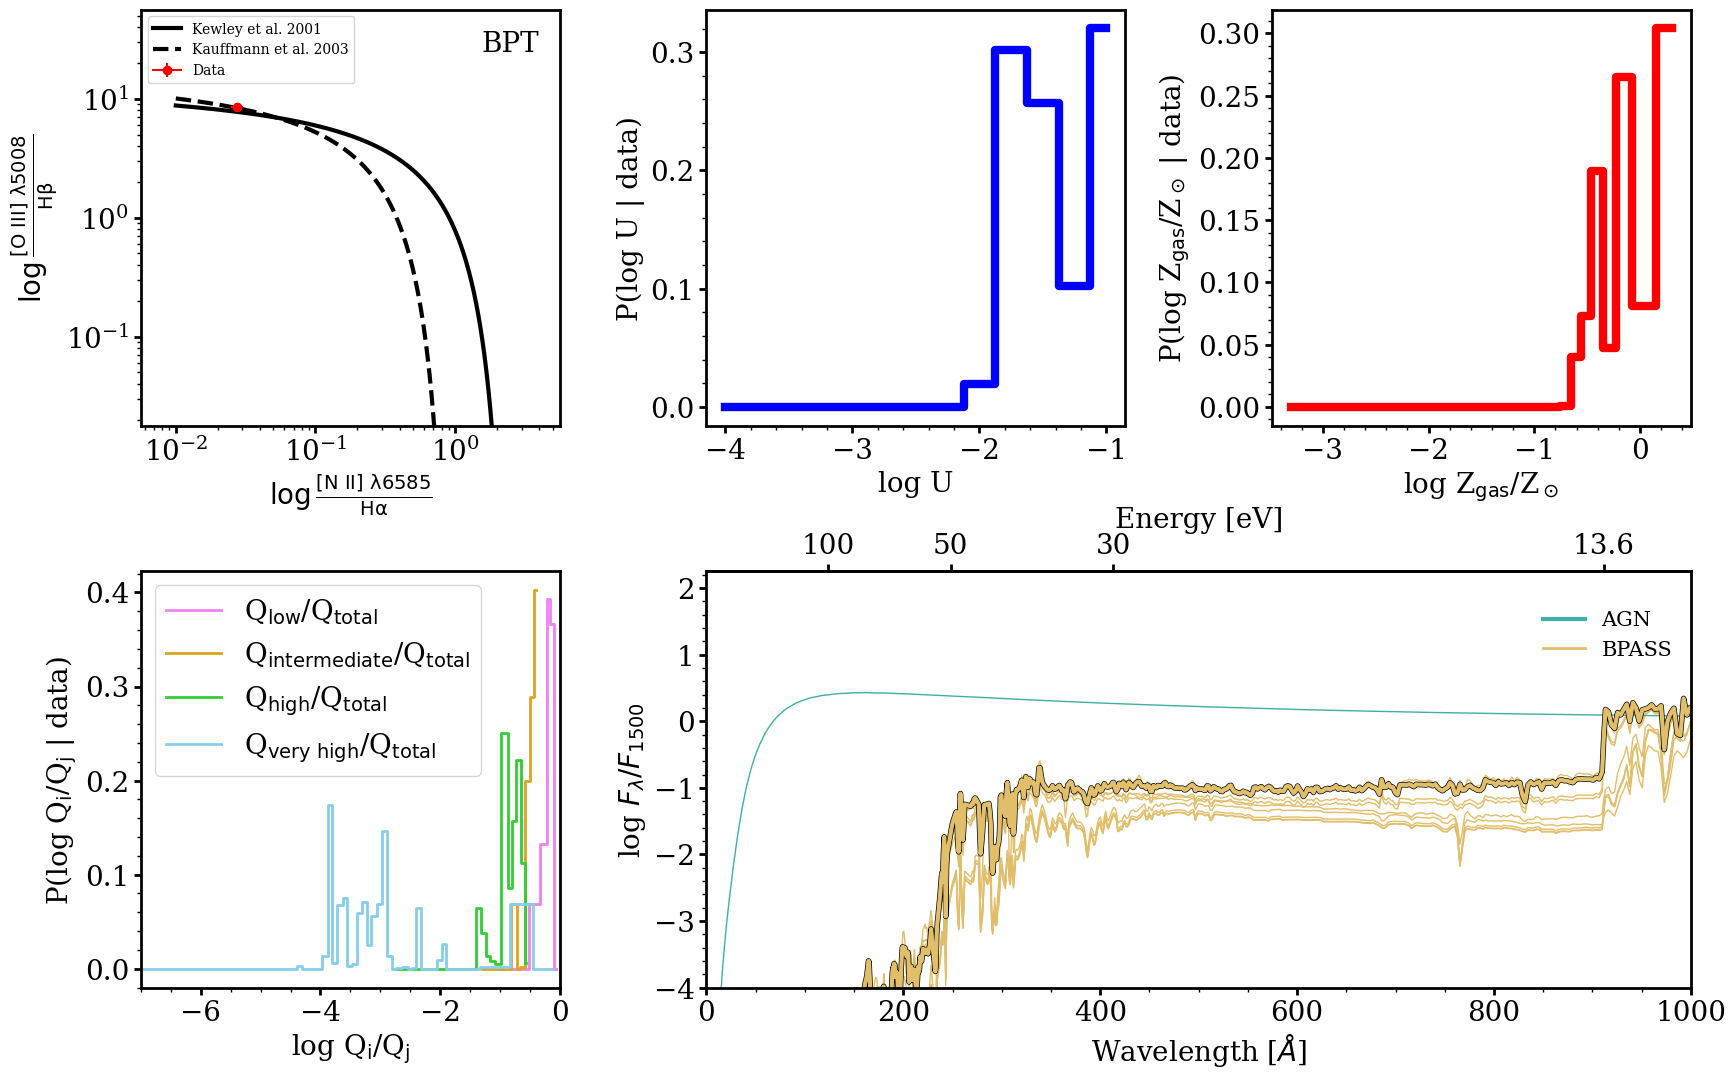

In [63]:
oiii_ubler = 135.94
oiii_ubler_unc = 0.41
hb_ubler = 16.04
hb_ubler_unc = 0.26
nii_ubler = 1.07
nii_ubler_unc = 0.11
ha_ubler = 38.71 
ha_ubler_unc = 0.43

oiii_hb_ubler = oiii_ubler/hb_ubler
oiii_hb_ubler_unc = np.sqrt((oiii_hb_ubler)**2*((oiii_ubler_unc/oiii_ubler)**2 + (hb_ubler_unc/hb_ubler)**2))
nii_ha_ubler = nii_ubler/ha_ubler
nii_ha_ubler_unc = np.sqrt((nii_ha_ubler)**2*((nii_ubler_unc/nii_ubler)**2 + (ha_ubler_unc/ha_ubler)**2))




main_bpt(NII_Ha_data=nii_ha_ubler, OIII_Hb_data=oiii_hb_ubler, NII_Ha_uncertainty=nii_ha_ubler_unc, OIII_Hb_uncertainty=oiii_hb_ubler_unc, n_most_likely=10)

In [ ]:
matches = main_bpt(NII_Ha_data=10**-0.5, OIII_Hb_data=10**-0.45, NII_Ha_uncertainty=10**-1.2, OIII_Hb_uncertainty=10**-0.6, n_most_likely=100)

In [10]:
matches.columns

Index(['index', 'data_OIII_Hb', 'data_NII_Ha', 'sed', 'model_OIII', 'model_Hb',
       'model_NII', 'model_Ha', 'logU', 'zgas', 'hden', 'Q_total', 'Q_low',
       'Q_intermediate', 'Q_high', 'Q_very_high', 'model_OIII_Hb',
       'log_model_OIII_Hb', 'model_NII_Ha', 'log_model_NII_Ha',
       'log_likelihood_OIII_Hb', 'log_likelihood_NII_Ha', 'likelihood_BPT',
       'likelihood_BPT_norm'],
      dtype='object')

In [35]:
matches

,index,data_OIII_Hb,data_NII_Ha,sed,model_OIII,model_Hb,model_NII,model_Ha,logU,zgas,...,Q_high,Q_very_high,model_OIII_Hb,log_model_OIII_Hb,model_NII_Ha,log_model_NII_Ha,log_likelihood_OIII_Hb,log_likelihood_NII_Ha,likelihood_BPT,likelihood_BPT_norm
0,59336,4.466836,0.1,mbh3/sedmbh3_hden3_z2.0_logU-3.0,0.163110,0.030345,0.231300,0.090126,-3.00,2.0,...,1.877936e+11,2.042934e+12,5.375185,0.730393,2.566407,0.409326,-0.065385,-764.010810,0.000000e+00,0.000000e+00
1,59036,4.466836,0.1,mbh3/sedmbh3_hden4_z2.0_logU-3.0,1.902800,0.328280,2.569600,0.987030,-3.00,2.0,...,1.877936e+11,2.042934e+12,5.796271,0.763149,2.603366,0.415535,-0.140057,-787.079467,0.000000e+00,0.000000e+00
2,59301,4.466836,0.1,mbh3/sedmbh3_hden2_z2.0_logU-3.0,0.014692,0.002908,0.021584,0.008597,-3.00,2.0,...,1.877936e+11,2.042934e+12,5.052443,0.703501,2.510731,0.399800,-0.027176,-729.906884,9.855202e-318,7.608611e-322
3,59440,4.466836,0.1,mbh3/sedmbh3_hden4_z2.0_logU-2.75,6.768800,0.563800,4.274500,1.728900,-2.75,2.0,...,1.877936e+11,2.042934e+12,12.005676,1.079387,2.472381,0.393115,-4.503799,-706.869075,1.134190e-309,8.781522e-314
4,59425,4.466836,0.1,mbh3/sedmbh3_hden3_z2.0_logU-2.75,0.605110,0.052940,0.395430,0.159990,-2.75,2.0,...,1.877936e+11,2.042934e+12,11.430110,1.058050,2.471592,0.392977,-3.842350,-706.398793,3.517150e-309,2.723170e-313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,58184,4.466836,0.1,mbh8/sedmbh8_hden3_z1.0_logU-4.0,0.000286,0.001287,0.002679,0.003614,-4.00,1.0,...,1.681249e+17,7.821753e+16,0.222328,-0.653005,0.741456,-0.129915,-1.427659,-51.677788,8.641660e-24,6.690846e-28
496,59161,4.466836,0.1,mbh3/sedmbh3_hden4_z1.0_logU-2.0,24.892000,3.310900,8.101000,10.882000,-2.00,1.0,...,1.877936e+11,2.042934e+12,7.518197,0.876114,0.744440,-0.128170,-0.737832,-52.159746,1.063834e-23,8.236786e-28
497,58697,4.466836,0.1,mbh4/sedmbh4_hden2_z0.5_logU-3.25,0.002056,0.001677,0.003865,0.005196,-3.25,0.5,...,3.728511e+12,2.793597e+13,1.226232,0.088573,0.743851,-0.128514,-0.832189,-52.064354,1.064935e-23,8.245310e-28
498,46280,4.466836,0.1,hden2/BPASSv2.2.1_imf170_300_burst_single_mode...,0.000035,0.000131,0.000272,0.000369,-4.00,0.7,...,4.673510e+03,6.545832e+02,0.263968,-0.578448,0.737267,-0.132375,-1.399785,-51.005015,1.741343e-23,1.348243e-27


In [18]:
matches['sed'][0].split('_hden')[0]

'mbh3/sedmbh3'

In [13]:
f'{BPASS_path}{matches.sed[0]}.con'

'/Users/njc5787/Research/cloudy_model_library/cloudy_model_library_complete/BPASS/solar_abundances/hden3/BPASSv2.2.1_imf100_300_burst_single_models/sedBPASSv2.2.1_imf100_300_burst_single.ascii_age11.0_zstar0.15_hden3_z0.15_logU-1.75.con'

In [ ]:


clean_cloudy_con_file(f'{BPASS_path}{matches.sed[0]}.con')

,wave,incident,trans,DiffOut,net trans,reflc,total,reflin,outlin,lineID,cont,nLine
0,2.992930e+11,0.000088,0.0,1.781000e-11,1.781000e-11,0.000041,0.000041,0.0,0.0,,,0.0
1,2.982970e+11,0.000089,0.0,1.799000e-11,1.799000e-11,0.000042,0.000042,0.0,0.0,,,0.0
2,2.973040e+11,0.000090,0.0,1.817000e-11,1.817000e-11,0.000042,0.000042,0.0,0.0,,,0.0
3,2.963150e+11,0.000091,0.0,1.836000e-11,1.836000e-11,0.000043,0.000043,0.0,0.0,,,0.0
4,2.953290e+11,0.000091,0.0,1.855000e-11,1.855000e-11,0.000043,0.000043,0.0,0.0,,,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9239,1.461500e-04,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.0,,,0.0
9240,1.418420e-04,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.0,,,0.0
9241,1.376600e-04,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.0,,,0.0
9242,1.336010e-04,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.0,0.0,,,0.0


In [21]:
all_models_with_qs

,N_4_765.147A,N_3_991.000A,C_3_977.020A,C_2_904.142A,C_2_1036.34A,C_2_1037.02A,S_4_1062.66A,H_1_1215.68A,N_5_1238.82A,N_5_1242.80A,...,sed,binary_or_single,history,imf,Q_total,Q_low,Q_intermediate,Q_high,Q_very_high,mbh
hden3/BPASSv2.2.1_imf170_300_burst_binary_models/sedBPASSv2.2.1_imf170_300_burst_binary.ascii_age7.1_zstar0.1_hden3_z0.1_logU-2.75,4.609400e-05,8.455600e-06,0.003117,0.000119,0.000939,0.001190,1.126800e-04,0.823320,1.150800e-07,5.956600e-08,...,BPASSv2.2.1_imf170_300_burst_binary.ascii,binary,burst,170_300,6.181809e+06,3.840057e+06,1.949325e+06,1.141909e+06,4.024118e+04,NaN
hden3/BPASSv2.2.1_imf170_300_burst_binary_models/sedBPASSv2.2.1_imf170_300_burst_binary.ascii_age6.1_zstar0.4_hden3_z0.4_logU-3.75,1.747100e-09,8.054900e-10,0.000031,0.000014,0.000018,0.000022,2.816100e-09,0.058002,0.000000e+00,0.000000e+00,...,BPASSv2.2.1_imf170_300_burst_binary.ascii,binary,burst,170_300,1.600474e+08,1.232513e+08,4.747371e+07,1.073280e+07,1.250047e+04,NaN
hden3/BPASSv2.2.1_imf170_300_burst_binary_models/sedBPASSv2.2.1_imf170_300_burst_binary.ascii_age7.2_zstar2.0_hden3_z2.0_logU-1.25,1.269500e-03,1.661200e-02,0.038420,0.002015,0.013792,0.016849,1.904100e-02,1.094000,1.665900e-03,8.743800e-04,...,BPASSv2.2.1_imf170_300_burst_binary.ascii,binary,burst,170_300,1.305911e+06,7.123009e+05,5.483304e+05,2.932462e+05,1.540309e+03,NaN
hden3/BPASSv2.2.1_imf170_300_burst_binary_models/sedBPASSv2.2.1_imf170_300_burst_binary.ascii_age7.8_zstar0.05_hden3_z0.05_logU-2.0,3.519800e-04,1.406100e-04,0.039419,0.000504,0.017364,0.022059,1.149800e-02,3.939400,3.767800e-06,1.998000e-06,...,BPASSv2.2.1_imf170_300_burst_binary.ascii,binary,burst,170_300,2.768973e+05,1.930144e+05,9.473766e+04,3.919922e+04,4.037895e+02,NaN
hden3/BPASSv2.2.1_imf170_300_burst_binary_models/sedBPASSv2.2.1_imf170_300_burst_binary.ascii_age6.9_zstar0.5_hden3_z0.5_logU-3.75,7.905100e-09,3.739600e-09,0.000144,0.000017,0.000089,0.000112,3.836100e-08,0.066223,0.000000e+00,0.000000e+00,...,BPASSv2.2.1_imf170_300_burst_binary.ascii,binary,burst,170_300,7.990522e+06,5.208316e+06,2.417780e+06,1.162595e+06,7.208846e+02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mbh5/sedmbh5_hden3_z0.5_logU-1.5,3.209900e-02,7.621600e-03,0.174860,0.000990,0.000869,0.000989,6.153300e-04,6.014600,3.224200e-01,2.351300e-01,...,NaN,NaN,NaN,NaN,5.873908e+14,1.081072e+14,5.366544e+13,7.045067e+13,3.473402e+14,5.0
mbh5/sedmbh5_hden3_z0.3_logU-1.25,1.202600e-01,7.045600e-03,0.291840,0.001831,0.001165,0.001418,7.739700e-04,8.085600,6.504700e-01,4.641700e-01,...,NaN,NaN,NaN,NaN,5.873908e+14,1.081072e+14,5.366544e+13,7.045067e+13,3.473402e+14,5.0
mbh5/sedmbh5_hden2_z0.4_logU-1.5,3.917400e-03,6.753400e-04,0.019803,0.000125,0.000078,0.000132,6.283600e-05,0.701310,3.412700e-02,2.452800e-02,...,NaN,NaN,NaN,NaN,5.873908e+14,1.081072e+14,5.366544e+13,7.045067e+13,3.473402e+14,5.0
mbh5/sedmbh5_hden3_z0.1_logU-2.0,9.329800e-03,1.182800e-03,0.099707,0.000460,0.000511,0.000626,4.422600e-04,13.001000,6.349500e-02,3.588800e-02,...,NaN,NaN,NaN,NaN,5.873908e+14,1.081072e+14,5.366544e+13,7.045067e+13,3.473402e+14,5.0


In [54]:
matches.sort_values('model_OIII', ascending=False)

,index,data_OIII_Hb,data_NII_Ha,sed,model_OIII,model_Hb,model_NII,model_Ha,logU,zgas,...,Q_high,Q_very_high,model_OIII_Hb,log_model_OIII_Hb,model_NII_Ha,log_model_NII_Ha,log_likelihood_OIII_Hb,log_likelihood_NII_Ha,likelihood_BPT,likelihood_BPT_norm
84,59334,7.079458,0.050119,mbh3/sedmbh3_hden4_z2.0_logU-2.0,36.428000,2.345900,9.588000,7.332500,-2.00,2.0,...,1.877936e+11,2.042934e+12,15.528369,1.191126,1.307603,0.116476,-8.965437,-790.633525,0.0,0.0
96,59323,7.079458,0.050119,mbh3/sedmbh3_hden4_z2.0_logU-2.25,28.244000,1.529100,8.061300,4.782400,-2.25,2.0,...,1.877936e+11,2.042934e+12,18.470996,1.266490,1.685618,0.226759,-16.298016,-1337.429105,0.0,0.0
35,58904,7.079458,0.050119,mbh4/sedmbh4_hden4_z2.0_logU-2.25,24.474000,1.092400,4.682400,3.253900,-2.25,2.0,...,3.728511e+12,2.793597e+13,22.403881,1.350323,1.439012,0.158064,-29.494314,-964.511777,0.0,0.0
29,59129,7.079458,0.050119,mbh3/sedmbh3_hden4_z2.0_logU-2.5,16.390000,0.945420,6.232300,2.941400,-2.50,2.0,...,1.877936e+11,2.042934e+12,17.336210,1.238954,2.118821,0.326094,-13.212645,-2139.764492,0.0,0.0
57,58837,7.079458,0.050119,mbh4/sedmbh4_hden4_z2.0_logU-2.5,15.244000,0.684070,3.713400,2.039000,-2.50,2.0,...,3.728511e+12,2.793597e+13,22.284269,1.347998,1.821187,0.260355,-29.035685,-1568.341166,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,57854,7.079458,0.050119,mbh6/sedmbh6_hden2_z2.0_logU-3.75,0.000180,0.000246,0.001000,0.000694,-3.75,2.0,...,1.219116e+15,3.675925e+15,0.731586,-0.135734,1.439595,0.158240,-5.060882,-965.322291,0.0,0.0
1,58995,7.079458,0.050119,mbh4/sedmbh4_hden3_z2.0_logU-4.0,0.000149,0.001601,0.006287,0.004572,-4.00,2.0,...,3.728511e+12,2.793597e+13,0.092973,-1.031645,1.375027,0.138311,-6.130381,-877.691420,0.0,0.0
9,58945,7.079458,0.050119,mbh4/sedmbh4_hden2_z2.0_logU-3.75,0.000085,0.000310,0.001413,0.000884,-3.75,2.0,...,3.728511e+12,2.793597e+13,0.274386,-0.561639,1.598159,0.203620,-5.816148,-1198.213633,0.0,0.0
31,59641,7.079458,0.050119,mbh5/sedmbh5_hden2_z2.0_logU-4.0,0.000019,0.000135,0.000501,0.000382,-4.00,2.0,...,7.045067e+13,3.473402e+14,0.138276,-0.859253,1.310634,0.117481,-6.051135,-794.448903,0.0,0.0
